In [1]:
import sys
sys.path.append("../")

from scripts.direct_training import direct_training
from scripts.fine_tuning import fine_tuning

pre_trained = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        labels="ace",
        num_layers=4,
    )
).sort_values("n_train")

pre_trained_models = {
    row.n_train: row.id for row in pre_trained.itertuples()
}
pre_trained_models

{100: '23.06.25-10.51.58-801842',
 330: '23.06.12-11.16.02-192600',
 1000: '23.06.12-12.18.55-375510',
 3300: '23.06.12-14.42.48-148294',
 10000: '23.06.08-20.33.15-394025',
 33000: '23.06.14-07.28.24-804165',
 100000: '23.06.15-17.18.28-722517'}

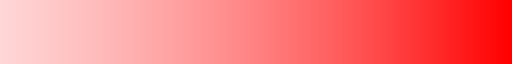

In [2]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from plotting_utils import colours

n_pretrains = sorted(pre_trained_models.keys())
cmap = LinearSegmentedColormap.from_list("mycmap", ["white", colours["ace"]])

gradient = cmap(np.linspace(0.4, 1, len(n_pretrains))**2)
color_gradient = dict(zip(n_pretrains, gradient))

# show the gradient
LinearSegmentedColormap.from_list("mycmap", gradient)

In [7]:
finetuned_results = {
    label: fine_tuning.to_dataframe(
        config=dict(
            pretrain_id=id,
            finetune_dataset="C-GAP-17",
            finetune_labels="dft",
            seed=42,
            checkpoint="best",
        )).sort_values("n_finetune").reset_index(drop=True)
    for label, id in pre_trained_models.items()
}

finetuned_results[10_000][["n_finetune", "test_force_rmse", "test_per_atom_energy_rmse"]]

,n_finetune,test_force_rmse,test_per_atom_energy_rmse
0,25,0.856994,0.067080
1,50,0.844948,0.071744
2,100,0.805975,0.061604
3,200,0.776633,0.053871
4,400,0.755753,0.051929
5,800,0.741915,0.052876
6,1600,0.716415,0.047915
7,3200,0.691077,0.045149


In [8]:
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-GAP-17",
        labels="dft",
    )
).groupby("n_train").min().reset_index()

direct_results[["n_train", "test_force_rmse", "test_per_atom_energy_rmse"]]

,n_train,test_force_rmse,test_per_atom_energy_rmse
0,25,1.231181,0.166456
1,50,1.138545,0.141982
2,100,1.028837,0.122863
3,200,0.944449,0.092603
4,400,0.892192,0.082821
5,800,0.820543,0.065986
6,1600,0.763852,0.054446
7,3200,0.707432,0.047711


In [9]:
import matplotlib.pyplot as plt

def cleanup(ax, yticks=None):
    xticks = list(direct_results.n_train)
    ax.set_xscale("log")
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel("Number of Training Structures")

    if yticks is None:
        yticks = [round(y) for y in ax.get_yticks()]
    ax.set_yscale("log")
    ax.set_yticks(yticks, yticks)

    ax.minorticks_off()
    # move spines apart
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])


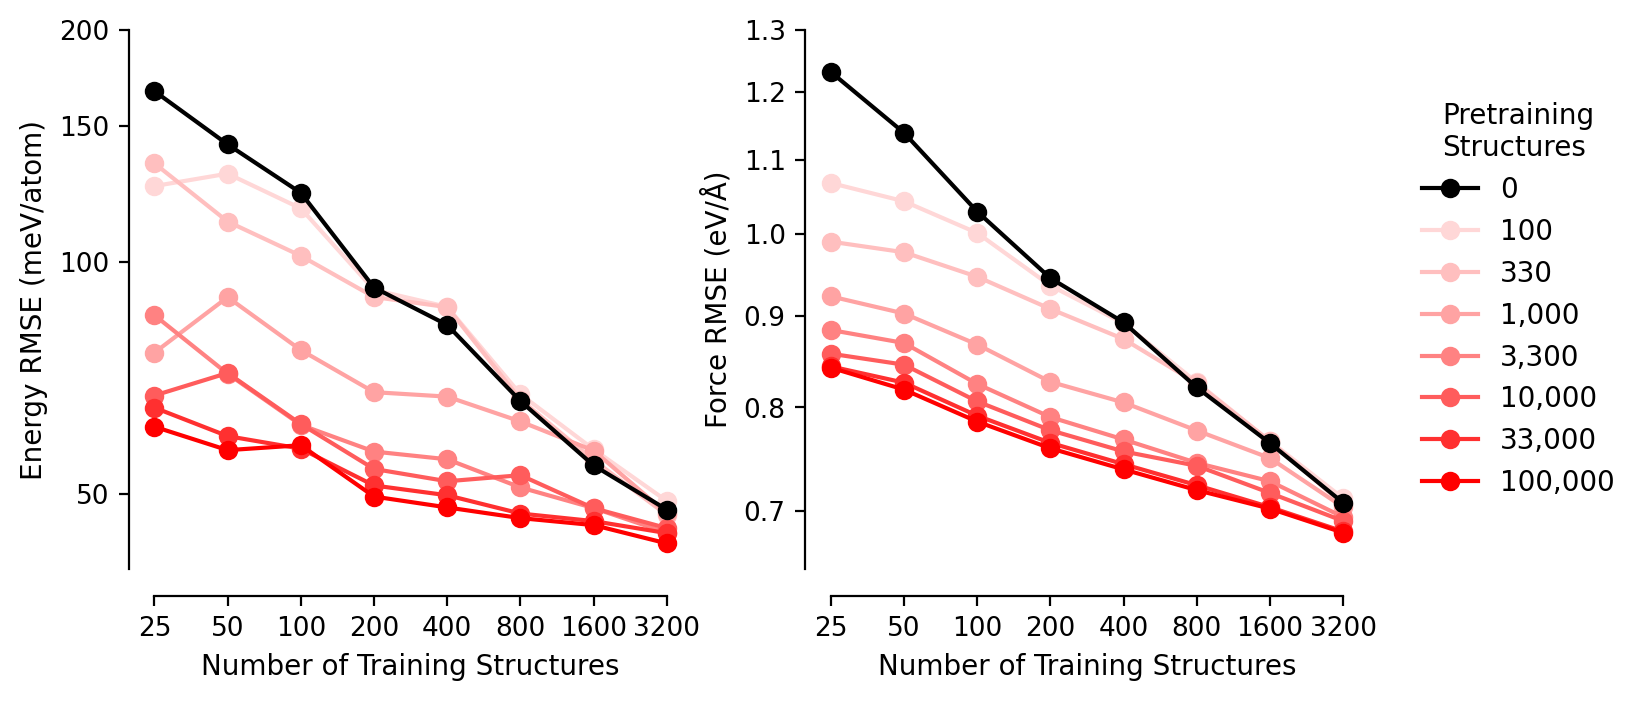

In [10]:
from collections import defaultdict
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, colours, empirical as empirical_labels, synthetic as synthetic_labels
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(style_defaults)

fig, (energy_ax, force_ax ) = plt.subplots(ncols=2, figsize=(8, 3.5))


def plot_results(results, **kwargs):
    energy_ax.plot(
        results.n_train if "n_train" in results else results.n_finetune,
        results.test_per_atom_energy_rmse * 1000,
        "-o",
        **kwargs,
    )

    line, = force_ax.plot(
        results.n_train if "n_train" in results else results.n_finetune,
        results.test_force_rmse,
        "-o",
        **kwargs,
    )
    return line

direct_line = plot_results(direct_results, c=colours["dft"], label=0, zorder=10)


## FINETUNING

for n_pretrain, results in finetuned_results.items():    
    plot_results(results, c=color_gradient[n_pretrain], label=f"{n_pretrain:,}")

cleanup(energy_ax, yticks=[50, 100, 150, 200])
energy_ax.set_ylabel("Energy RMSE (meV/atom)")
cleanup(force_ax, yticks=[0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])
force_ax.set_ylabel("Force RMSE (eV/Å)")

energy_ax.set_ylim(40, 200)
force_ax.set_ylim(0.65, 1.3)

plt.legend(
    title="Pretraining\nStructures",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
)

plt.savefig("../figures/n-pre-train.svg", bbox_inches="tight", transparent=True)

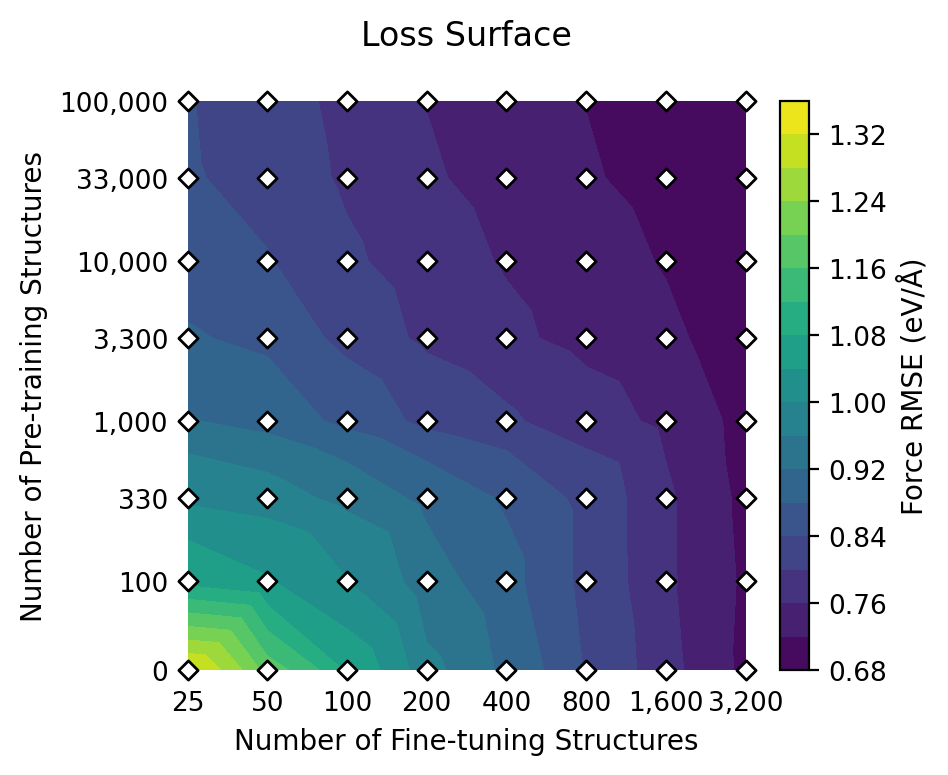

In [7]:
# grid plot of n_pretrain vs n_finetune

xs, ys, zs = [], [], []

for n_pretrain, results in finetuned_results.items():
    for _, row in results.iterrows():
        xs.append(row.n_finetune)
        ys.append(n_pretrain)
        zs.append(row.test_force_rmse)

# add direct training as pretraining with 0 structures
for _, row in direct_results.iterrows():
    xs.append(row.n_train)
    ys.append(0)
    zs.append(row.test_force_rmse)


plt.figure(figsize=(4.5, 3.7))

plt.tricontourf(xs, ys, zs, cmap="viridis", levels=20)
plt.colorbar(label="Force RMSE (eV/Å)")
plt.scatter(xs, ys, facecolor="w", edgecolors="k", marker="D", clip_on=False, s=24, zorder=10)

plt.yscale('symlog', linthresh=min(finetuned_results.keys()), linscale=0.5)
plt.xscale("log")

xticks = sorted(set(xs))
yticks = sorted(set(ys))

plt.xticks(xticks, [f"{x:,}" for x in xticks])
plt.yticks(yticks, [f"{y:,}" for y in yticks])
plt.minorticks_off()

plt.xlabel("Number of Fine-tuning Structures")
plt.ylabel("Number of Pre-training Structures")
plt.title("Loss Surface", pad=20)

plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)